In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy
from scipy.stats import beta
import matplotlib
import pandas as pd
import csv


matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = False

num_samples = 1000

from models import BetaBernoulli, SumOfBetaEce, Model
from data_utils import datafile_dict, datasize_dict, num_classes_dict, prepare_data

In [2]:
datafile = datafile_dict['cifar100']
categories, observations, confidences, idx2category, category2idx, labels = prepare_data(datafile, False)

reader = csv.reader(open("../data/cifar100/id2class_for_padhraic.csv", 'r'))
class2id = {}
for row in reader:
    k, v = row
    class2id[k] = v
    
print(class2id)

{'0': 'lion', '1': 'chimpanzee', '2': 'trout', '3': 'orchid', '4': 'cloud', '5': 'maple_tree', '6': 'elephant', '7': 'mushroom', '8': 'bus', '9': 'orange', '10': 'cockroach', '11': 'shark', '12': 'palm_tree', '13': 'television', '14': 'clock', '15': 'otter', '16': 'cup', '17': 'poppy', '18': 'aquarium_fish', '19': 'possum', '20': 'lamp', '21': 'mouse', '22': 'pine_tree', '23': 'table', '24': 'house', '25': 'turtle', '26': 'sweet_pepper', '27': 'pear', '28': 'streetcar', '29': 'telephone', '30': 'whale', '31': 'bicycle', '32': 'sunflower', '33': 'lizard', '34': 'couch', '35': 'tiger', '36': 'butterfly', '37': 'hamster', '38': 'worm', '39': 'tulip', '40': 'lobster', '41': 'tractor', '42': 'spider', '43': 'woman', '44': 'seal', '45': 'bear', '46': 'tank', '47': 'fox', '48': 'beaver', '49': 'cattle', '50': 'squirrel', '51': 'castle', '52': 'boy', '53': 'girl', '54': 'crab', '55': 'kangaroo', '56': 'wolf', '57': 'plate', '58': 'skyscraper', '59': 'snake', '60': 'plain', '61': 'caterpillar',

In [3]:
# accuracy models
accuracy_model = copy.deepcopy(BetaBernoulli(k=100, prior=None))
accuracy_model.update_batch(categories, observations)

# ece models for each class
ece_models = [copy.deepcopy(SumOfBetaEce(num_bins=10, weight=None, prior_alpha=None, prior_beta=None)) for i in range(100)]
for class_idx in range(100):
    mask_idx = [i for i in range(len(observations)) if categories[i] == class_idx]
    observations_sublist = [observations[i] for i in mask_idx]
    confidences_sublist = [confidences[i] for i in mask_idx]
    ece_models[class_idx].update_batch(confidences_sublist, observations_sublist)

In [4]:
# draw samples from posterior of classwise accuracy
accuracy_samples = accuracy_model.sample(num_samples) # (num_categories, num_samples)
ece_samples = np.array([ece_models[class_idx].sample(num_samples) for class_idx in range(100)]).squeeze() # (num_categories, num_samples)

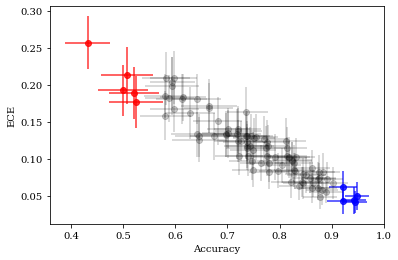

In [5]:
# plot
x = np.mean(accuracy_samples, axis=1)
y = np.mean(ece_samples, axis=1)
xerr = np.std(accuracy_samples, axis=1)
yerr = np.std(ece_samples, axis=1)


k = 5
# most accuracy top k
idx = x.argsort()[-k:][::-1]
plt.errorbar(x[idx], y[idx],
            xerr=xerr[idx],
            yerr=yerr[idx],
            fmt='o', alpha=0.8, color='b')


# least accuracy top k
idx = x.argsort()[:k]
plt.errorbar(x[idx], y[idx],
            xerr=xerr[idx],
            yerr=yerr[idx],
            fmt='o', alpha=0.8, color='r')



# other predicted classes
idx = x.argsort()[10:-k]
plt.errorbar(x[idx], y[idx],
            xerr=xerr[idx],
            yerr=yerr[idx],
            fmt='o', alpha=0.2, color='k')



plt.xlabel('Accuracy')
plt.ylabel('ECE')
plt.savefig('../figures/scatter.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

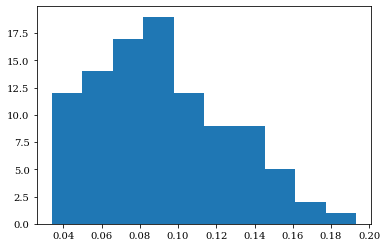

In [6]:
plt.hist(np.mean(ece_samples, axis=1));
plt.show()

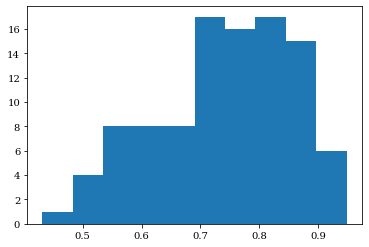

In [7]:
plt.hist(np.mean(accuracy_samples, axis=1));
plt.show()

# Bayesian ECE

In [24]:
def plot_bayesian_reliability_diagram(model, figname=None):
    
    params_alpha, params_beta = ece_model.get_params()
    mode_acc = (params_alpha - 1) / (params_alpha + params_beta - 2)
    beta_posterior_p025 = beta.ppf(0.025, params_alpha, params_beta)
    beta_posterior_p975 = beta.ppf(0.975, params_alpha, params_beta)
    
    error_upper = beta_posterior_p975 - mode_acc
    error_lower = mode_acc - beta_posterior_p025

    num_bins = mode_acc.shape[0]
    
    fig, ax1 = plt.subplots(figsize=(4, 4))
    color = 'tab:red'
    # ax1.grid(True)
    ax1.plot([i + 0.5 for i in range(num_bins)], mode_acc , c="r", linestyle="--")
    ax1.errorbar([i + 0.5 for i in range(num_bins)], mode_acc, yerr=(error_lower, error_upper), fmt='o', color='r')
    ax1.plot(np.linspace(0, 1, num_bins+1), linestyle="--", linewidth=3, c="gray")
    ax1.fill_between([i + 0.5 for i in range(num_bins)], mode_acc, \
                     np.linspace(0, 1, num_bins + 1)[:-1] + 0.05, color="gray", alpha=0.3)
                 
    ax1.set_xlim((0.0, num_bins))
    ax1.set_xlabel("Score(Model Confidence)", fontsize=14)
    ax1.set_xticks(range(num_bins + 1))
    ax1.set_xticklabels(["%.1f" % i for i in np.linspace(0, 1, num_bins + 1)])
    ax1.set_ylim((0.0, 1.0))
    ax1.set_ylabel("Accuracy", fontsize=14)
                 
    plt.tight_layout()
    plt.savefig(figname, format='pdf', dpi=300, bbox_inches='tight')
    
def plot_posterior_ece(model, figname,  num_samples = 1000):
    fig, ax = plt.subplots(figsize=(4, 4))
    color = 'tab:red'
    samples = model.sample(num_samples)
    ax.hist(samples,bins=100)
    plt.tight_layout()
    plt.savefig(figname, format='pdf', dpi=300, bbox_inches='tight')
    
def plot_samples(samples_prior, samples_posterior, figname):
    plt.hist(samples_prior, color = 'blue', label='prior')
    plt.hist(samples_posterior, color = 'red', label='posterior')
    plt.legend()
    plt.xlabel('ECE')
    plt.savefig(figname, format='pdf', dpi=300, bbox_inches='tight')

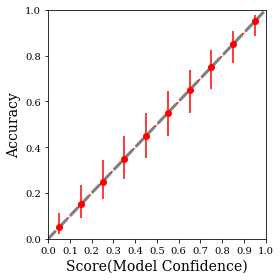

In [31]:
# prior reliability diagram
peusdo_count = 100
ece_model = SumOfBetaEce(num_bins = 10, peusdo_count=peusdo_count)
plot_bayesian_reliability_diagram(ece_model, '../figures/prior_reliability_peusdo_count%.2f.pdf' % peusdo_count)
samples_prior = ece_model.sample(num_samples)

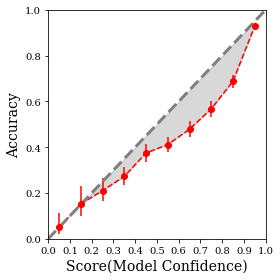

In [32]:
ece_model.update_batch(confidences, observations)
plot_bayesian_reliability_diagram(ece_model,'../figures/posterior_reliability_peusdo_count%.2f.pdf' % peusdo_count);
samples_posterior = ece_model.sample(num_samples)
# plot_posterior_ece(ece_model, num_samples = 10000)

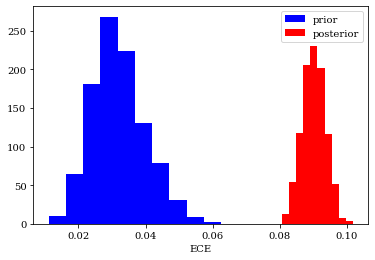

In [33]:
plot_samples(samples_prior, samples_posterior, '../figures/ece_samples_peusdo_count%.2f.pdf' % peusdo_count)